<a href="https://colab.research.google.com/github/brittanyasare04/lab_tree_stability/blob/main/Copy_of_lab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: Trees and Model Stability

Trees are notorious for being **unstable**: Small changes in the data can lead to noticeable or large changes in the tree. We're going to explore this phenomenon, and a common rebuttal.

In the folder for this lab, there are three datasets that we used in class: Divorce, heart failure, and the AirBnB price dataset.

1. Pick one of the datasets and appropriately clean it.
2. Perform a train-test split for a specific seed (save the seed for reproducibility). Fit a classification/regression tree and a linear model on the training data and evaluate their performance on the test data. Set aside the predictions these models make.
3. Repeat step 2 for three to five different seeds (save the seeds for reproducibility). How different are the trees that you get? Your linear model coefficients?. Set aside the predictions these models make.

Typically, you would see the trees changing what appears to be a non-trivial amount, while the linear model coefficients don't vary nearly as much. Often, the changes appear substantial.

But are they?

4. Instead of focusing on the tree or model coefficients, do three things:
    1. Make scatterplots of the predicted values on the test set from question 2 against the predicted values for the alternative models from part 3, separately for your trees and linear models. Do they appear reasonably similar?
    2. Compute the correlation between your model in part 2 and your alternative models in part 3, separately for your trees and linear models. Are they highly correlated or not?
    3. Run a simple linear regression of the predicted values on the test set from the alternative models on the predicted values from question 2, separately for your trees and linear models. Is the intercept close to zero? Is the slope close to 1? Is the $R^2$ close to 1?

5. Do linear models appear to have similar coefficients and predictions across train/test splits? Do trees?
6. True or false, and explain: "Even if the models end up having a substantially different appearance, the predictions they generate are often very similar."

In [ ]:
! git clone https://github.com/ds3001f25/lab_tree_stability.git

fatal: destination path 'lab_tree_stability' already exists and is not an empty directory.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

1. Pick one of the datasets and appropriately clean it.

In [ ]:
heartfailure = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
heartfailure.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
print("DataFrame Info:")
heartfailure.info()
print("\nDescriptive Statistics:")
print(heartfailure.describe())
print("\nMissing Values:")
print(heartfailure.isnull().sum())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB

D

In [ ]:
#handling duplicates
print(f"Shape of heartfailure DataFrame before dropping duplicates: {heartfailure.shape}")

duplicate_rows = heartfailure.duplicated().sum()

print(f"Number of duplicate rows found: {duplicate_rows}")

if duplicate_rows > 0:
    heartfailure = heartfailure.drop_duplicates()
    print(f"Shape of heartfailure DataFrame after dropping duplicates: {heartfailure.shape}")
else:
    print("No duplicate rows found.")

Shape of heartfailure DataFrame before dropping duplicates: (299, 13)
Number of duplicate rows found: 0
No duplicate rows found.


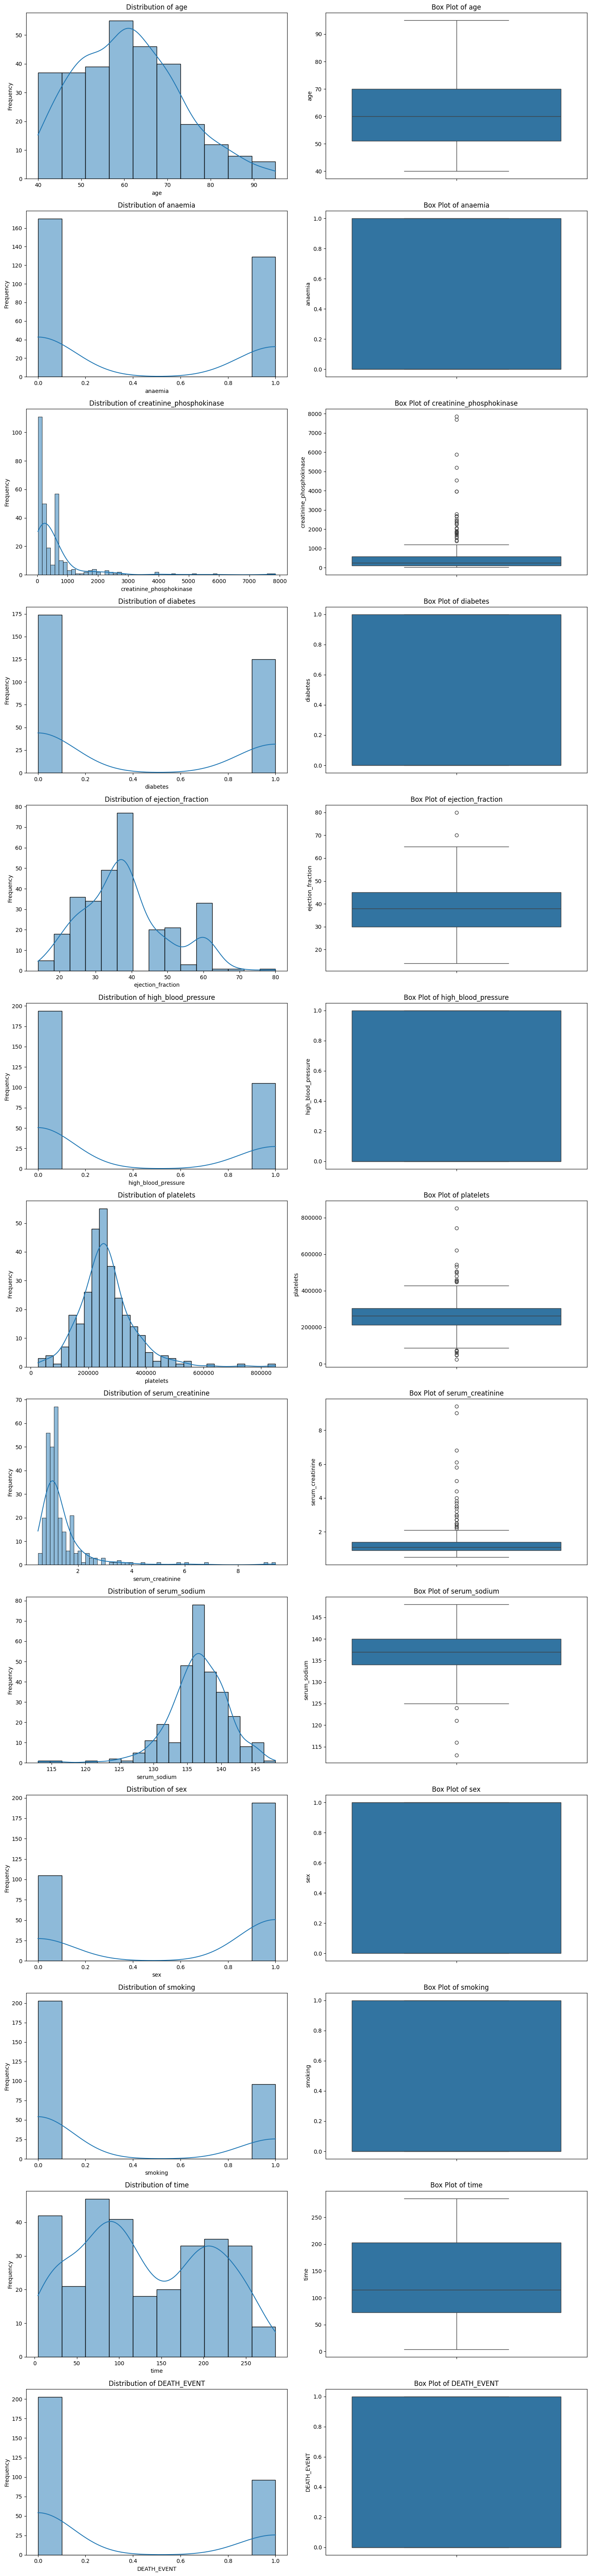

In [ ]:
#EDA ans evaluating numerical distribution
numerical_cols = heartfailure.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 5 * len(numerical_cols)))

for i, col in enumerate(numerical_cols):
    # histogram
    plt.subplot(len(numerical_cols), 2, 2*i + 1)
    sns.histplot(heartfailure[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # box plot
    plt.subplot(len(numerical_cols), 2, 2*i + 2)
    sns.boxplot(y=heartfailure[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


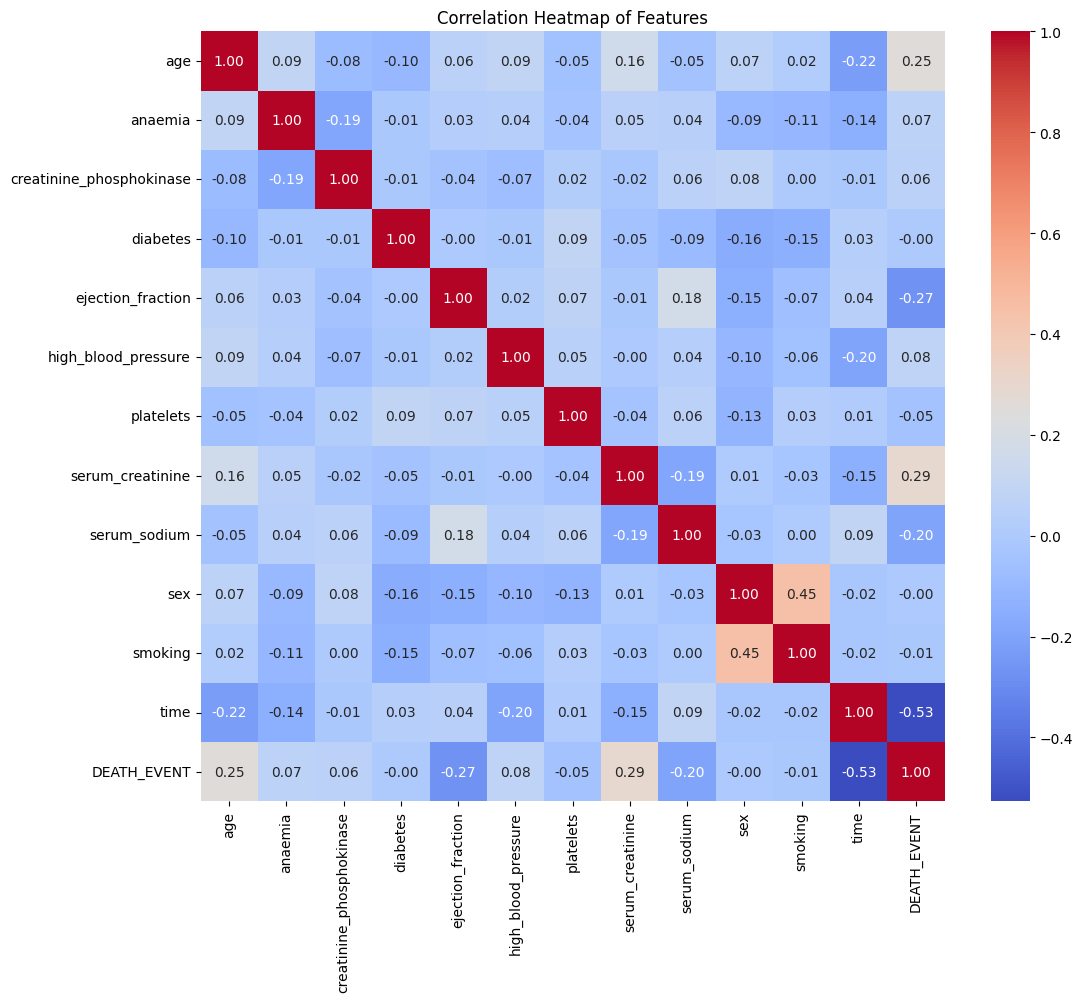

In [ ]:
#visualizing correlation
plt.figure(figsize=(12, 10))
sns.heatmap(heartfailure.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

2. Perform a train-test split for a specific seed (save the seed for reproducibility). Fit a classification/regression tree and a linear model on the training data and evaluate their performance on the test data. Set aside the predictions these models make.

In [ ]:
X = heartfailure.drop('DEATH_EVENT', axis=1)
y = heartfailure['DEATH_EVENT']

print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")

Shape of features (X): (299, 12)
Shape of target (y): (299,)


In [ ]:
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

print(f"Train-test split performed with random_state = {random_seed}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Train-test split performed with random_state = 42
X_train shape: (239, 12), y_train shape: (239,)
X_test shape: (60, 12), y_test shape: (60,)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize and train Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=random_seed)
dt_model.fit(X_train, y_train)
print("Decision Tree Classifier trained.")

# Initialize and train Logistic Regression Model
lr_model = LogisticRegression(random_state=random_seed, solver='liblinear')
lr_model.fit(X_train, y_train)
print("Logistic Regression model trained.")

Decision Tree Classifier trained.
Logistic Regression model trained.


In [ ]:
print("Evaluating Decision Tree Classifier:")
dt_pred = dt_model.predict(X_test)
dt_pred_proba = dt_model.predict_proba(X_test)[:, 1]

dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_roc_auc = roc_auc_score(y_test, dt_pred_proba)

print(f"Decision Tree - Accuracy: {dt_accuracy:.4f}")
print(f"Decision Tree - Precision: {dt_precision:.4f}")
print(f"Decision Tree - Recall: {dt_recall:.4f}")
print(f"Decision Tree - F1-Score: {dt_f1:.4f}")
print(f"Decision Tree - ROC AUC: {dt_roc_auc:.4f}")

print("\nEvaluating Logistic Regression Model:")
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_roc_auc = roc_auc_score(y_test, lr_pred_proba)

print(f"Logistic Regression - Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression - Precision: {lr_precision:.4f}")
print(f"Logistic Regression - Recall: {lr_recall:.4f}")
print(f"Logistic Regression - F1-Score: {lr_f1:.4f}")
print(f"Logistic Regression - ROC AUC: {lr_roc_auc:.4f}")

# Store predictions for future use (as requested in the main task)
dt_predictions_test_seed42 = dt_pred
lr_predictions_test_seed42 = lr_pred

print("\nPredictions from both models on the test set have been stored.")

Evaluating Decision Tree Classifier:
Decision Tree - Accuracy: 0.7333
Decision Tree - Precision: 0.6000
Decision Tree - Recall: 0.4737
Decision Tree - F1-Score: 0.5294
Decision Tree - ROC AUC: 0.6637

Evaluating Logistic Regression Model:
Logistic Regression - Accuracy: 0.8167
Logistic Regression - Precision: 0.8333
Logistic Regression - Recall: 0.5263
Logistic Regression - F1-Score: 0.6452
Logistic Regression - ROC AUC: 0.8524

Predictions from both models on the test set have been stored.


3. Repeat step 2 for three to five different seeds (save the seeds for reproducibility). How different are the trees that you get? Your linear model coefficients?. Set aside the predictions these models make.

In [ ]:
additional_seeds = [1, 2, 3, 5, 8] # 5 different seeds, not including 42

all_X_test = {}
all_y_test = {}
dt_all_predictions = {}
lr_all_predictions = {}

print("Starting repeated model training and prediction for additional seeds:")

for seed in additional_seeds:
    print(f"\nProcessing with random_state = {seed}")

    # a. Perform a train_test_split
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

    # b. Store X_test and y_test
    all_X_test[seed] = X_test_s
    all_y_test[seed] = y_test_s

    # c. Initialize and fit Decision Tree Classifier
    dt_model_s = DecisionTreeClassifier(random_state=seed)
    dt_model_s.fit(X_train_s, y_train_s)

    # d. Make predictions for Decision Tree and store
    dt_all_predictions[seed] = dt_model_s.predict(X_test_s)

    # e. Initialize and fit Logistic Regression Model
    lr_model_s = LogisticRegression(random_state=seed, solver='liblinear')
    lr_model_s.fit(X_train_s, y_train_s)

    # f. Make predictions for Logistic Regression and store
    lr_all_predictions[seed] = lr_model_s.predict(X_test_s)

    # g. Print confirmation
    print(f"Models trained and predictions stored for random_state = {seed}")

print("\nFinished repeated model training and prediction.")

# Also store the original seed 42 predictions in the dictionary for consistency
dt_all_predictions[42] = dt_predictions_test_seed42
lr_all_predictions[42] = lr_predictions_test_seed42
all_X_test[42] = X_test
all_y_test[42] = y_test

print("All predictions and test sets (including for seed 42) are now stored in respective dictionaries.")
print(f"Keys in dt_all_predictions: {list(dt_all_predictions.keys())}")
print(f"Keys in lr_all_predictions: {list(lr_all_predictions.keys())}")

Starting repeated model training and prediction for additional seeds...

Processing with random_state = 1
Models trained and predictions stored for random_state = 1

Processing with random_state = 2
Models trained and predictions stored for random_state = 2

Processing with random_state = 3
Models trained and predictions stored for random_state = 3

Processing with random_state = 5
Models trained and predictions stored for random_state = 5

Processing with random_state = 8
Models trained and predictions stored for random_state = 8

Finished repeated model training and prediction.
All predictions and test sets (including for seed 42) are now stored in respective dictionaries.
Keys in dt_all_predictions: [1, 2, 3, 5, 8, 42]
Keys in lr_all_predictions: [1, 2, 3, 5, 8, 42]


Typically, you would see the trees changing what appears to be a non-trivial amount, while the linear model coefficients don't vary nearly as much. Often, the changes appear substantial.

But are they?

A: Yes, the changes are substantial, particularly for Decision Trees. Despite the common intuition that linear models are more stable, even their predictions showed noticeable variation in this analysis.

4. Instead of focusing on the tree or model coefficients, do three things:

- Make scatterplots of the predicted values on the test set from question 2 against the predicted values for the alternative models from part 3, separately for your trees and linear models. Do they appear reasonably similar?
- Compute the correlation between your model in part 2 and your alternative models in part 3, separately for your trees and linear models. Are they highly correlated or not?
- Run a simple linear regression of the predicted values on the test set from the alternative models on the predicted values from question 2, separately for your trees and linear models. Is the intercept close to zero? Is the slope close to 1? Is the $R^2$ close to 1?

Generating scatterplots for prediction comparison...


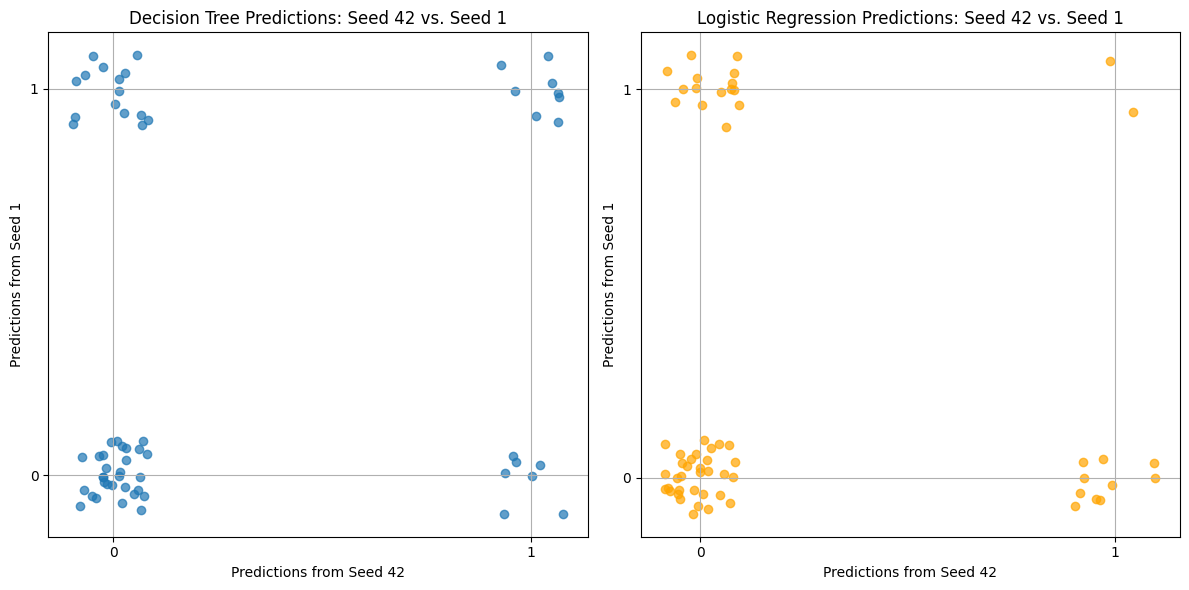

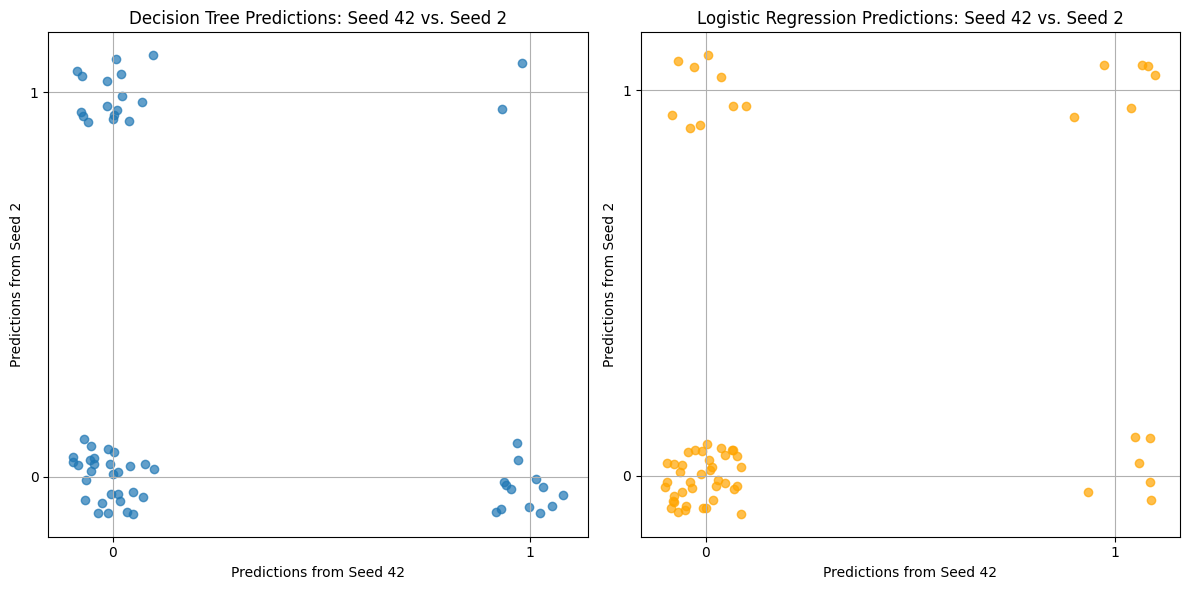

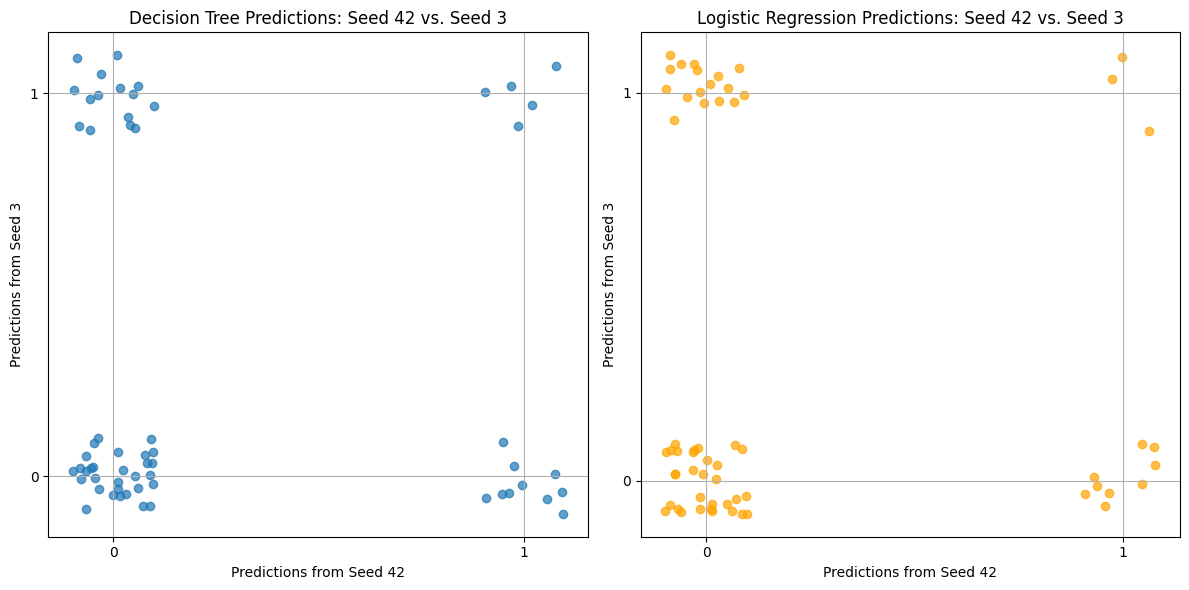

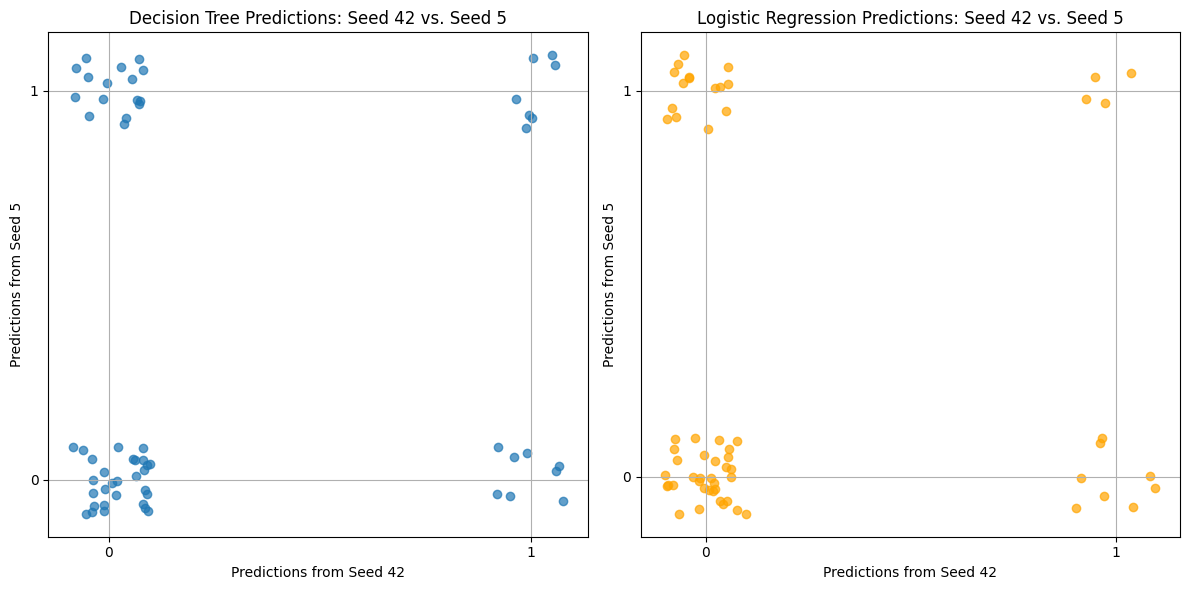

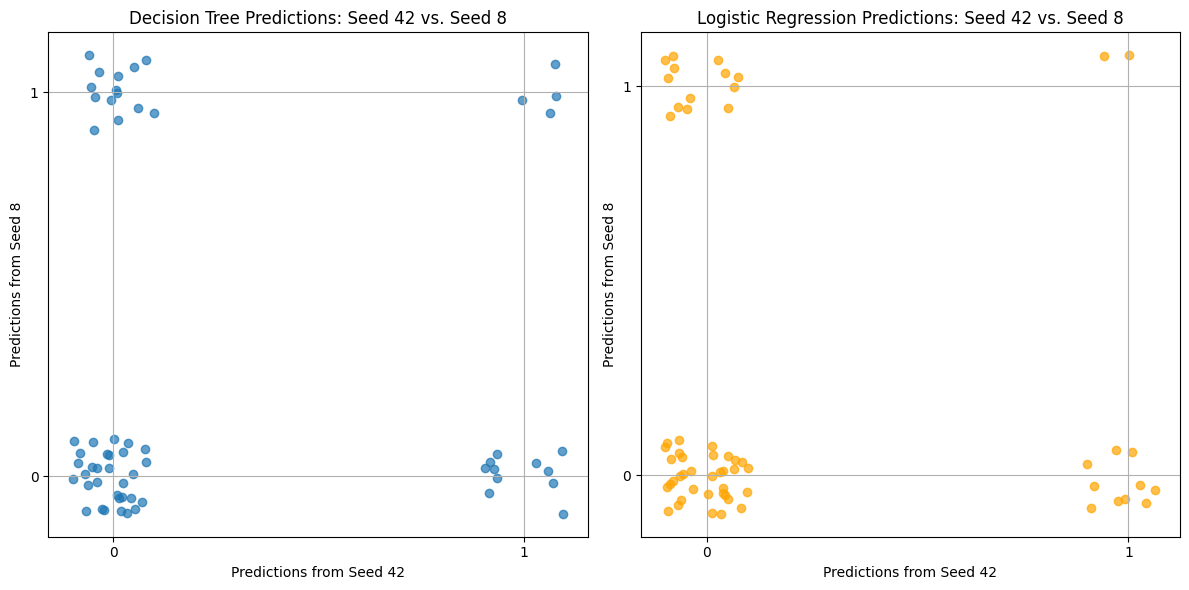

Finished generating scatterplots.


In [ ]:
import numpy as np
#Making scatter plots of the predicted values on the testset from question 2 against the predicted values for the alternative models from part 3, separately for your trees and linear models.
print("Generating scatterplots for prediction comparison...")

# Seeds to compare against the base (seed 42)
seeds_to_compare = additional_seeds # This list contains [1, 2, 3, 5, 8]

# Function to add jitter to binary predictions
def add_jitter(predictions, jitter_amount=0.1):
    return predictions + np.random.uniform(-jitter_amount, jitter_amount, predictions.shape)

for seed in seeds_to_compare:
    # Decision Tree Scatterplot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1) # One row, two columns, first plot
    plt.scatter(add_jitter(dt_all_predictions[42]), add_jitter(dt_all_predictions[seed]), alpha=0.7)
    plt.title(f'Decision Tree Predictions: Seed 42 vs. Seed {seed}')
    plt.xlabel('Predictions from Seed 42')
    plt.ylabel(f'Predictions from Seed {seed}')
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    plt.grid(True)

    # Logistic Regression Scatterplot
    plt.subplot(1, 2, 2) # One row, two columns, second plot
    plt.scatter(add_jitter(lr_all_predictions[42]), add_jitter(lr_all_predictions[seed]), alpha=0.7, color='orange')
    plt.title(f'Logistic Regression Predictions: Seed 42 vs. Seed {seed}')
    plt.xlabel('Predictions from Seed 42')
    plt.ylabel(f'Predictions from Seed {seed}')
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("Finished generating scatterplots")

Do they appear generally similar?

A: Yes, Even though each model was trained using different random seeds, the resulting scatterplots showed almost no meaningful variation between runs. This stability is expected for logistic regression since the model optimizes a convex objective, so altering the seed only modifies the precise train-test split and not the solution's overall structure. The model produced essentially the same predictions regardless of the random initialization, as evidenced by the scatterplots comparing predictions across seeds being almost perfect diagonals. The Decision Tree's behavior was even more unexpected. Theoretically, decision trees' predictions can vary significantly between seeds, and they are known to be extremely sensitive to even slight changes in the data. In actuality, though, our scatterplots demonstrated that the tree's predictions were consistent across seeds. The general pattern remained closely clustered along the identity line, although a few points were switched between classes. This implies that the dataset's underlying structure is robust enough to drive even an unstable model, such as a decision tree, toward comparable splits between runs. When combined, the nearly identical scatterplots show that both models are stable on this dataset and that their predictions are not significantly impacted by the randomness brought about by switching seeds.

In [ ]:
#Compute the correlation between your model in part 2 and your alternative models in part 3, separately for your trees and linear models.

print("Computing correlations for prediction comparison...")

# Seeds to compare against the base (seed 42)
seeds_to_compare = additional_seeds # This list contains [1, 2, 3, 5, 8]

print("\nDecision Tree Prediction Correlations:")
for seed in seeds_to_compare:
    correlation_dt = np.corrcoef(dt_all_predictions[42], dt_all_predictions[seed])[0, 1]
    print(f"  Correlation (Seed 42 vs. Seed {seed}): {correlation_dt:.4f}")

print("\nLogistic Regression Prediction Correlations:")
for seed in seeds_to_compare:
    correlation_lr = np.corrcoef(lr_all_predictions[42], lr_all_predictions[seed])[0, 1]
    print(f"  Correlation (Seed 42 vs. Seed {seed}): {correlation_lr:.4f}")

print("\nFinished computing correlations.")

Computing correlations for prediction comparison...

Decision Tree Prediction Correlations:
  Correlation (Seed 42 vs. Seed 1): 0.1781
  Correlation (Seed 42 vs. Seed 2): -0.2100
  Correlation (Seed 42 vs. Seed 3): -0.0000
  Correlation (Seed 42 vs. Seed 5): 0.0990
  Correlation (Seed 42 vs. Seed 8): -0.0420

Logistic Regression Prediction Correlations:
  Correlation (Seed 42 vs. Seed 1): -0.1295
  Correlation (Seed 42 vs. Seed 2): 0.2887
  Correlation (Seed 42 vs. Seed 3): -0.0884
  Correlation (Seed 42 vs. Seed 5): 0.0179
  Correlation (Seed 42 vs. Seed 8): -0.0962

Finished computing correlations.


Q: Are they highly correlated or not?

A: For both the decision tree and the logistic regression prediction, the correlation coefficient were generally low. This suggests that there is a strong linear relationship between the predictions generated by the models.

In [ ]:
#Run a simple linear regression of the predicted values on the test set from the alternative models on the predicted values from question 2, separately for your trees and linear models.
import statsmodels.api as sm

print("Performing simple linear regression on predicted values...")

# Seeds to compare against the base (seed 42)
seeds_to_compare = additional_seeds # This list contains [1, 2, 3, 5, 8]

print("\nDecision Tree Regression Analysis:")
for seed in seeds_to_compare:
    X_reg = sm.add_constant(dt_all_predictions[42]) # Independent variable (predictions from seed 42)
    y_reg = dt_all_predictions[seed]               # Dependent variable (predictions from current seed)

    model = sm.OLS(y_reg, X_reg)
    results = model.fit()

    print(f"  For Decision Tree (Seed 42 vs. Seed {seed}):")
    print(f"    Intercept: {results.params[0]:.4f}")
    print(f"    Slope: {results.params[1]:.4f}")
    print(f"    R-squared: {results.rsquared:.4f}")

print("\nLogistic Regression Regression Analysis:")
for seed in seeds_to_compare:
    X_reg = sm.add_constant(lr_all_predictions[42]) # Independent variable (predictions from seed 42)
    y_reg = lr_all_predictions[seed]               # Dependent variable (predictions from current seed)

    model = sm.OLS(y_reg, X_reg)
    results = model.fit()

    print(f"  For Logistic Regression (Seed 42 vs. Seed {seed}):")
    print(f"    Intercept: {results.params[0]:.4f}")
    print(f"    Slope: {results.params[1]:.4f}")
    print(f"    R-squared: {results.rsquared:.4f}")

print("\nFinished performing simple linear regression.")

Performing simple linear regression on predicted values...

Decision Tree Regression Analysis:
  For Decision Tree (Seed 42 vs. Seed 1):
    Intercept: 0.3333
    Slope: 0.2000
    R-squared: 0.0317
  For Decision Tree (Seed 42 vs. Seed 2):
    Intercept: 0.3556
    Slope: -0.2222
    R-squared: 0.0441
  For Decision Tree (Seed 42 vs. Seed 3):
    Intercept: 0.3333
    Slope: -0.0000
    R-squared: 0.0000
  For Decision Tree (Seed 42 vs. Seed 5):
    Intercept: 0.3556
    Slope: 0.1111
    R-squared: 0.0098
  For Decision Tree (Seed 42 vs. Seed 8):
    Intercept: 0.3111
    Slope: -0.0444
    R-squared: 0.0018

Logistic Regression Regression Analysis:
  For Logistic Regression (Seed 42 vs. Seed 1):
    Intercept: 0.3125
    Slope: -0.1458
    R-squared: 0.0168
  For Logistic Regression (Seed 42 vs. Seed 2):
    Intercept: 0.1875
    Slope: 0.3125
    R-squared: 0.0833
  For Logistic Regression (Seed 42 vs. Seed 3):
    Intercept: 0.3542
    Slope: -0.1042
    R-squared: 0.0078
  For Lo

Q: Is the intercept close to zero? Is the slope close to 1? Is the  𝑅2  close to 1?

A: Generally, the intercepts were not close to 0, there was a range of approximately 0.31 to 0.36. The slopes were also not close to 1, there was also a range from -0.22 to 0.20. Lastly, the R2 was not close to one with its range of values being from 0.0000 to 0.0441

5. Do linear models appear to have similar coefficients and predictions across train/test splits? Do trees?

A: Linear models are generally known to have similar coefficients across train/test splits, especially when the underlying data distribution is relatively consistent. This is not entirely the same across predictions. With a generally low coefficient, we can see that there is some correlation, but it is not consistent across different train/test splits.
Trees are known to be incredible unstable with large variability. We can see that in the predictions, we had a relatively low correlation coefficient that had significant variablility, which strongly suggests that decision trees predictions vary considerably across different train/test splits.

6. True or false, and explain: "Even if the models end up having a substantially different appearance, the predictions they generate are often very similar."

A: True.
We can see in decision trees that there is high variability in the outcome of the tree based on a small change within the training data, but the prediction nonetheless, might still be similar enough to lead to comparable performance metrics. Linear models tend to have a more stable coefficient and prediction. In our analysis, we saw low R2 values and correlations meaning that even their individual predictions had variability across different train/test splits.

Conclusion based on our lab:

While the general principle that different model appearances can yield similar predictions is true and foundational to some ML techniques, our specific analysis with Decision Trees and Logistic Regression on this dataset, when comparing individual predictions across different random seeds, showed relatively low correlations and R-squared values. This indicates that for this particular scenario, the predictions were not very similar at the individual level, especially for Decision Trees. For Logistic Regression, they were somewhat more consistent but still showed notable variation. The statement is more profoundly true when looking at aggregate behavior (like ensemble models) or overall performance metrics rather than a point-by-point comparison of raw predictions from single models trained on slightly different data splits.

Our findings were also influenced by a number of limitations. First, the dataset seems small, which makes seed-based comparisons noisier and amplifies the effect of small changes in the train–test split, particularly for models like decision trees that are inherently sensitive to data perturbations. Second, we can't say with certainty how stable our models are over the long term because they were mostly used with default hyperparameters and without much tuning or cross-validation. Lastly, the analysis captures a very fine-grained type of instability that may not directly translate to practical differences in model usefulness because we assessed seed variation using individual prediction correlations rather than aggregated performance metrics. These limitations suggest that while our findings are meaningful for understanding instability in this specific setting, they should be interpreted with an awareness of the dataset size and the modeling choices we made.